# Underdamped Langevin Diffusion simulation

The Underdamped Langevin diffusion (ULD) is an SDE of the form:

\begin{align*}
    d \mathbf{x}_t &= \mathbf{v}_t \, dt \\
    d \mathbf{v}_t &= - \gamma \, \mathbf{v}_t \, dt - u \,
    \nabla \! f( \mathbf{x}_t ) \, dt + \sqrt{2 \gamma u} \, d W_t,
\end{align*}

where $\mathbf{x}_t, \mathbf{v}_t \in \mathbb{R}^d$ represent the position
and velocity, $W$ is a Brownian motion in $\mathbb{R}^d$,
$f: \mathbb{R}^d \rightarrow \mathbb{R}$ is a potential function, and
$\gamma , u \in \mathbb{R}^{d \times d}$ are diagonal matrices governing
the friction and the dampening of the system.

## ULD for Markov Chain Monte Carlo (MCMC)

ULD is commonly used in MCMC applications since it allows us to sample from its stationary distribution $p(x) = \frac{\exp(-E(x))}{Z}$ even when its normalising constant $Z = \int p(x) dx$ is unknown. This is because only knowledge of $\nabla E$ is required (i.e. only the un-normalized log probability), which doesn't depend on $Z$. For an example of such an application see section 5.2 of the paper on [Single-seed generation of Brownian paths](https://arxiv.org/abs/2405.06464).

## ULD solvers in Diffrax

In addition to generic SDE solvers (which can solve any SDE including ULD), Diffrax has some solvers designed specifically for ULD. These are `diffrax.ALIGN` which has a 2nd order of strong convergence, and `diffrax.QUICSORT` and `diffrax.ShOULD` which are 3rd order solvers. Note that unlike ODE solvers which can have orders much larger than 5, very few types of SDEs permit solvers with a strong order greater than $1$ for general SDEs. However, we are able to achieve an unusually high strong order of 3 by exploiting properties of this specific additive noise SDE.

These Langevin-specific solvers only accept terms retuned by `diffrax.make_langevin_term`.

## A 1D Double Well

In this example we will simulate a simple double well, a [classic system](https://web.physics.ucsb.edu/~davidgrabovsky/files-teaching/Double%20Well%20Solutions.pdf) in quantum mechanics. This system is given by the potential $E(x) = \frac{1}{4} x^4 - 2 x^2$. In order to sample from this distribution we run many trajectories in parallel and take the last point. We could also run a single chain, however, in order to generate a multiple samples, we can only draw them once sufficient time has passed to re-equilibrate (lest the samples be correlated). Since spatial parallelism is cheaper than sequential in time, we simply run many chains.

In [1]:
from warnings import simplefilter


simplefilter(action="ignore", category=FutureWarning)
import diffrax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


t0, t1 = 0.0, 1000.0
dt0 = 0.1
saveat = diffrax.SaveAt(steps=True)

gamma = jnp.array([1.0], dtype=jnp.float32)
u = jnp.array([1.0], dtype=jnp.float32)
x0 = jnp.zeros((1,), dtype=jnp.float32)
v0 = jnp.zeros((1,), dtype=jnp.float32)
y0 = (x0, v0)

def solve(key):
    bm = diffrax.VirtualBrownianTree(
        t0, t1, tol=dt0 / 2, shape=(1,), key=key, levy_area=diffrax.SpaceTimeTimeLevyArea
    )
    # Here, we just specify the gradient of the energy function analytically
    terms = diffrax.make_langevin_term(gamma, u, lambda x: x ** 3 - 4 * x, bm, x0)

    solver = diffrax.QUICSORT()
    sol = diffrax.diffeqsolve(
        terms, solver, t0, t1, dt0=dt0, y0=y0, saveat=saveat, max_steps=int(t1 / dt0 + 100)
    )
    xs_quic, vs_quic = sol.ys
    return xs_quic, vs_quic


key = jax.random.key(0)
keys = jax.random.split(key, 1000)
xs, vs = jax.jit(jax.vmap(solve))(keys)

Let's see how samples look in comparison to the true distribution!

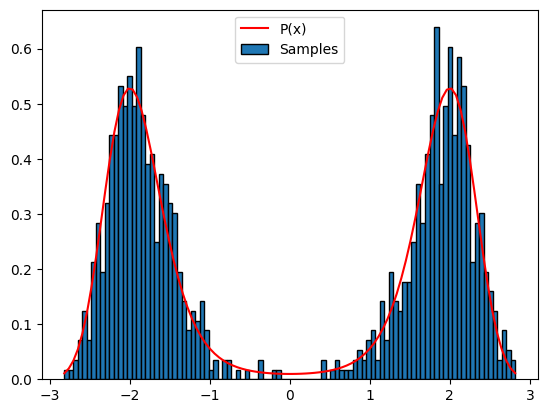

In [15]:
padding_idx = jnp.argmax(jnp.isinf(xs), axis=1).min()
x_quic = xs[:, (padding_idx - 1):padding_idx].squeeze()

def E(x):
    return 1 / 4 * x ** 4 - 2 * x ** 2

def Z():
    return jax.scipy.integrate.trapezoid(energies, rang)

rang = jnp.linspace(x_quic.min(), x_quic.max(), 100)
energies = jnp.exp(-E(rang))
plt.plot(rang,  energies / Z(), label='P(x)', color='red')
plt.hist(x_quic, bins=100, density=True, edgecolor='black', label='Samples')
plt.legend()
plt.show()

Now, let's look a few samples from the trajectory. We can see the trajectory generally stays in one well until a hopping event occurs and it jumps to the other well.

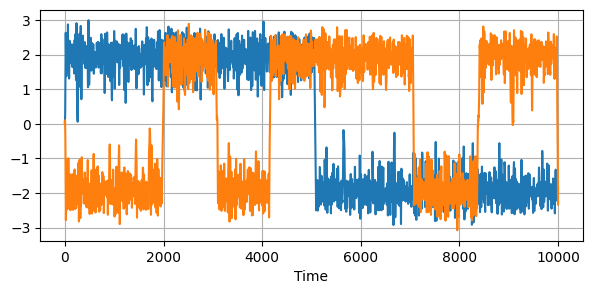

In [19]:
plt.figure(figsize=(7, 3))
for i in range(2):
    plt.plot(xs[i])
plt.xlabel("Time")
plt.grid()

plt.show()